In [1]:
### Imports and metadata ###

import os
import sys
import time
import glob
import numpy as np
import tensorflow as tf 
from keras import backend as K
from keras.layers import *
from keras.models import Model
from keras.losses import *
from keras.optimizers import *
import visualize
from Autoencoder import AutoEncoder
from AutoEncoderQuat import AutoEncoderQuat
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Using TensorFlow backend.


In [2]:
### Load data ###

data_path = 'data'
files = glob.glob(os.path.join(data_path, '*.csv'))
datasets = [np.genfromtxt(file, delimiter=',') for file in files]
labels = np.concatenate([[i]*len(ds) for i,ds in enumerate(datasets)], axis=0)
data = np.concatenate(datasets, axis=0)

# center all wrist positions to 0,0
data = data - np.expand_dims(data[:,0],axis=-1)

# normalize
data /= np.max(data)

# add cluster labels 
data_labeled = np.concatenate((data, np.expand_dims(labels, axis=1)), axis=-1)

batch_size=32

In [3]:
### Setup network ###

def sample_gaussian(tensor):
    z_mean, z_log_var = tensor
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape=(batch,dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

input_size = data.shape[1]
coding_dims = [50,40,30,25,15]

layers_enc = [Input(shape=(input_size,))]
layers_enc.append(BatchNormalization()(layers_enc[-1]))
for dim in coding_dims[:-1]:
    layers_enc.append(Dense(dim)(layers_enc[-1]))
    layers_enc.append(LeakyReLU()(layers_enc[-1]))
    
z_mean = Dense(coding_dims[-1])(layers_enc[-1])
z_log_var = Dense(coding_dims[-1])(layers_enc[-1])
z = Lambda(sample_gaussian, output_shape=(coding_dims[-1],))([z_mean, z_log_var])

encoder = Model(inputs=(layers_enc[0],), outputs=(z_mean, z_log_var, z))
print('encoder:')
encoder.summary()

layers_dec = [Input(shape=(coding_dims[-1],))]
for dim in coding_dims[::-1][1:]:
    layers_dec.append(Dense(dim)(layers_dec[-1]))
    layers_dec.append(LeakyReLU()(layers_dec[-1]))
layers_dec.append(Dense(input_size, activation='sigmoid')(layers_dec[-1]))

decoder = Model(inputs=(layers_dec[0],), outputs=(layers_dec[-1],))
print('decoder:')
decoder.summary()

outputs = decoder(encoder(layers_enc[0])[2])

full_model = Model(inputs=(layers_enc[0],), outputs=(outputs,))
print('full model:')
full_model.summary()


reconstruction_loss = mse(layers_enc[0], outputs) * input_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
full_model.add_loss(vae_loss)

full_model.compile(optimizer=rmsprop())


Instructions for updating:
Colocations handled automatically by placer.
encoder:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 66)           0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 66)           264         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           3350        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 50)           0           dense_1[0][0]                    
____________________________

In [4]:
### Train network ###

num_epochs = 100

full_model.fit(data, batch_size, epochs=num_epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
35168/35168 [==============================] - 9s 247us/step - loss: 1.2905
Epoch 2/200
35168/35168 [==============================] - 7s 201us/step - loss: 1.0495
Epoch 3/200
35168/35168 [==============================] - 7s 211us/step - loss: 1.0478
Epoch 4/200
35168/35168 [==============================] - 7s 206us/step - loss: 1.0474
Epoch 5/200
35168/35168 [==============================] - 7s 207us/step - loss: 1.0471
Epoch 6/200
35168/35168 [==============================] - 7s 209us/step - loss: 1.0465
Epoch 7/200
35168/35168 [==============================] - 8s 219us/step - loss: 1.0466
Epoch 8/200
35168/35168 [==============================] - 7s 206us/step - loss: 1.0464
Epoch 9/200
35168/35168 [==============================] - 7s 204us/step - loss: 1.0463
Epoch 10/200
35168/35168 [==============================] - 8s 218us/step - loss: 1.0463
Epoch 11/200
35168/35168 [==============================] - 8s 222us/st

35168/35168 [==============================] - 8s 213us/step - loss: 1.0457
Epoch 91/200
35168/35168 [==============================] - 7s 209us/step - loss: 1.0457
Epoch 92/200
35168/35168 [==============================] - 8s 218us/step - loss: 1.0457
Epoch 93/200
35168/35168 [==============================] - 7s 213us/step - loss: 1.0457
Epoch 94/200
35168/35168 [==============================] - 8s 217us/step - loss: 1.0457
Epoch 95/200
35168/35168 [==============================] - 8s 218us/step - loss: 1.0457
Epoch 96/200
35168/35168 [==============================] - 7s 208us/step - loss: 1.0457
Epoch 97/200
35168/35168 [==============================] - 7s 205us/step - loss: 1.0457
Epoch 98/200
35168/35168 [==============================] - 7s 199us/step - loss: 1.0457
Epoch 99/200
35168/35168 [==============================] - 7s 207us/step - loss: 1.0456
Epoch 100/200
35168/35168 [==============================] - 7s 209us/step - loss: 1.0457
Epoch 101/200
35168/35168 [======

35168/35168 [==============================] - 8s 219us/step - loss: 1.0457
Epoch 182/200
35168/35168 [==============================] - 8s 219us/step - loss: 1.0456
Epoch 183/200
35168/35168 [==============================] - 8s 216us/step - loss: 1.0457
Epoch 184/200
20288/35168 [================>.............] - ETA: 3s - loss: 1.0392

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


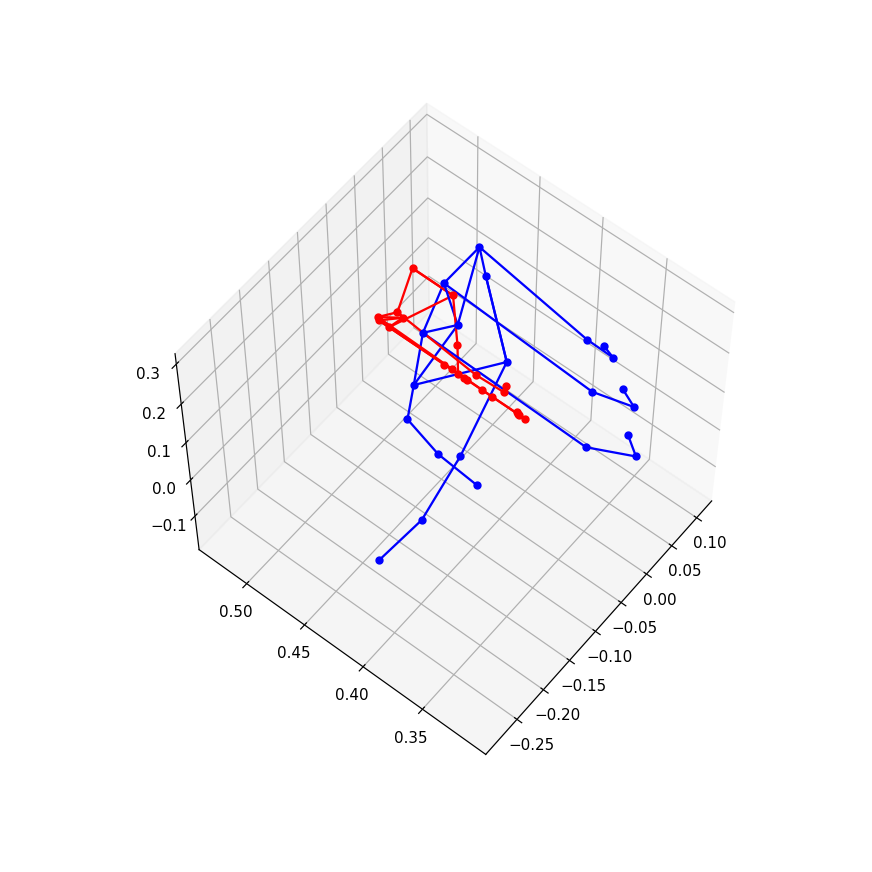

In [5]:
### Make predictions ###
%matplotlib notebook
encoded_hands = encoder.predict(data)
decoded_hands = decoder.predict(encoded_hands[2])
visualize.plot_reconstruction(data[0], decoded_hands[0], figsize=(8,8))

In [6]:
full_model.save('models/variational.h5')
encoder.save('models/variational_enc.h5')
decoder.save('models/variational_dec.h5')

In [ ]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(encoded_hands[2])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principal_components[:,0], principal_components[:,1], 
           principal_components[:,2], s=0.3)

In [ ]:
%matplotlib notebook
n_clusters = len(files)
print("number of clusters:", n_clusters)
km = KMeans(n_clusters=n_clusters, n_jobs=-1)
cluster_labels = np.expand_dims(km.fit_predict(encoded_hands[2], axis=1)

def cluster_to_color(cluster):
    colors = 'bgrcmykw'
    return colors[cluster]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pcc = np.concatenate((principal_components, cluster_labels), axis=1)
for cluster in range(n_clusters):
    c = pcc[pcc[:,3] == cluster]
    ax.scatter(c[:,0], c[:,1], c[:,2], s=0.3, c=cluster_to_color(cluster))

# %matplotlib notebook
reload(visualize)
encc = np.concatenate((encoded_hands, cluster_labels), axis=1)
for cluster in range(n_clusters):
    c = encc[encc[:,coding_dims[-1]] == cluster]
    choice = c[np.random.choice(range(c.shape[0]))][:-1]
    dec_choice = autoencoder.decode(np.expand_dims(choice, axis=0))
    visualize.plot_hand(dec_choice[0,:], color=cluster_to_color(cluster))